In [3]:
# 데이터복제를 의도치 않게 많이하면 터질때 이걸 쓰면 됨 
# 파이토치와 matplotlib 의 충돌 
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [48]:
import torch
from torch.utils import data
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import warnings
warnings.filterwarnings('ignore')

In [5]:
# CPU 혹은 GPU 장치 확인
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cpu')

In [7]:
# 배치 사이즈, 에포크 정함
BATCH_SIZE = 32
EPOCHS = 10

# 데이터 준비

In [13]:
trainset= datasets.MNIST(
    root = './data/',
    train = True,
    download = True,
    transform = transforms.Compose([transforms.ToTensor()]))

testset = datasets.MNIST(
    root = './data/',
    train = False,
    download = True,
    transform = transforms.Compose([transforms.ToTensor()]))

In [14]:
# 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                          batch_size= BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = testset,
                                          batch_size= BATCH_SIZE, shuffle = True)

# 데이터 확인

In [15]:
for (x_train, y_train) in train_loader:
    print('x_train:', x_train.size(), 'type:', x_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [27]:
print(len(train_loader))
print(len(trainset))

1875
60000


In [20]:
x_train.shape, y_train.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

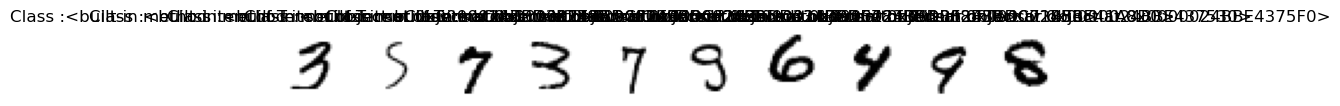

In [28]:
# 데이터셋 모얌 확인
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize)) # 10개 plot하기 위한 figure 크기 설정

for i in range(10):
    plt.subplot(1, 10, i + 1) # plot.subplot(rows, columns, index)
    plt.axis('off')
    plt.imshow(x_train[i, :, :, :].numpy().reshape(28, 28), cmap = 'gray_r')
    plt.title('Class :' + str(y_train[i].item))

# 다층 퍼셉트론 (MLP) 모델 설계하기 

In [41]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28) # 1차원 flatten 
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x 

### Optimizer, Objective Function 설정하기

In [42]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


### MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의

In [43]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [44]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset)/ BATCH_SIZE)
    test_accuracy = 100. * correct/len(test_loader.dataset)
    return test_loss, test_accuracy

In [45]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(
        epoch, test_loss, test_accuracy))

Train epoch: 1 [0/60000 (0%)]	Train Loss: 2.388263
Train epoch: 1 [6400/60000 (11%)]	Train Loss: 2.327208
Train epoch: 1 [12800/60000 (21%)]	Train Loss: 2.324368
Train epoch: 1 [19200/60000 (32%)]	Train Loss: 2.297911
Train epoch: 1 [25600/60000 (43%)]	Train Loss: 2.301207
Train epoch: 1 [32000/60000 (53%)]	Train Loss: 2.286302
Train epoch: 1 [38400/60000 (64%)]	Train Loss: 2.271455
Train epoch: 1 [44800/60000 (75%)]	Train Loss: 2.278845
Train epoch: 1 [51200/60000 (85%)]	Train Loss: 2.238190
Train epoch: 1 [57600/60000 (96%)]	Train Loss: 2.274751

[EPOCH: 1], 	Test Loss: 2.2307, 	Test Accuracy: 26.58 %

Train epoch: 2 [0/60000 (0%)]	Train Loss: 2.264360
Train epoch: 2 [6400/60000 (11%)]	Train Loss: 2.225914
Train epoch: 2 [12800/60000 (21%)]	Train Loss: 2.213742
Train epoch: 2 [19200/60000 (32%)]	Train Loss: 2.049357
Train epoch: 2 [25600/60000 (43%)]	Train Loss: 2.050159
Train epoch: 2 [32000/60000 (53%)]	Train Loss: 1.965218
Train epoch: 2 [38400/60000 (64%)]	Train Loss: 1.772012
Tr

# 합성곱 신경망 모델 생성

In [50]:
learning_rate = 0.001
batch_size = 100
num_classes = 10
epochs = 5

In [52]:
# input size 를 알기 위해서 
examples = enumerate(trainset)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1, 28, 28])

- W is the input volume - in your case 128
- K is the Kernel size - in your case 5
- P is the padding - in your case 0 i believe
- S is the stride - which you have not provided.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self): # layer 정의
        super().__init__()
        
        # input size = 28 x 28
        self.conv1 = nn.Conv2d(1, 10, kernel_size =  5) # input channel = 1, filter = 10, kernel 
        # ((W - K + 2P /S) + 1) 공식으로 인해 ( 28 -5  + 0) / 1 _ 1 =24 -> 24 x 24로 변환 
        # maxpooling  하면 12 x 12 